In [1]:
pip install scikit-learn scikit-image scipy seaborn matplotlib numpy opencv-python pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

Buat struktur folder dataset sebagai berikut:
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

In [3]:
data_awal = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)

        if img is None:
            print(f"Gagal membaca gambar: {img_path}")
            continue
        
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, (256, 700))  
        
        data_awal.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)

data_awal = np.array(data_awal)
labels = np.array(labels)

data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data_awal)):
	pass



# Augmentasi


In [4]:
def augment_flip(img: np.ndarray) -> np.ndarray:
    return cv.flip(img, 1)          

target_per_label = 100

label2idx = {}
for idx, lab in enumerate(labels):
    label2idx.setdefault(lab, []).append(idx)

for lab, idx_list in label2idx.items():
    existing = len(idx_list)                       
    need = target_per_label - existing          
    for n in range(need):
        base_idx  = idx_list[n % existing]         
        base_img  = data_awal[base_idx]
        aug_img   = augment_flip(base_img)       

        data_augmented.append(aug_img)
        labels_augmented.append(lab)

        new_name = f"{lab}_flip{n:04d}.png"
        file_name_augmented.append(new_name)
        paths_augmented.append(
            os.path.join("dataset_aug", lab, new_name))

data_final   = np.concatenate([data_awal, np.array(data_augmented)], axis=0)
labels_final = np.concatenate([labels,     np.array(labels_augmented)], axis=0)
file_name_final = np.concatenate([file_name, np.array(file_name_augmented)], axis=0)
print("Data sebelum augmentasi :", len(data_awal))   # 142
print("Data setelah  augmentasi :", len(data_final)) # 200


Data sebelum augmentasi : 142
Data setelah  augmentasi : 200


## Data Preparation

### Define Preprocessing Function


In [62]:
# def resize_grayscale_image(gambar_gray, tinggi_tujuan=700, lebar_tujuan=280):

#     baris, kolom = gambar_gray.shape[:2]
#     resized = np.zeros((tinggi_tujuan, lebar_tujuan), dtype=np.uint8)

#     skala_tinggi = baris / tinggi_tujuan
#     skala_lebar = kolom / lebar_tujuan

#     for i in range(tinggi_tujuan):
#         for j in range(lebar_tujuan):
#             src_i = min(int(i * skala_tinggi), baris - 1)
#             src_j = min(int(j * skala_lebar), kolom - 1)
#             resized[i, j] = gambar_gray[src_i, src_j]

#     return resized

def histogram_equalization(img):
    hist = np.zeros(256, dtype=int)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1
    cdf = hist.cumsum()
    cdf_normalized = ((cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())).astype(np.uint8)
    equalized = np.zeros_like(img)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            equalized[i, j] = cdf_normalized[img[i, j]]
    return equalized

def median_filter(image, ksize):
    pad = ksize // 2
    padded = np.pad(image, pad, mode='edge')
    output = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded[i:i+ksize, j:j+ksize]
            median_val = np.median(window)
            output[i, j] = median_val
    return output

def dilation(img):
    dilated = np.zeros_like(img)
    padded = np.pad(img, 1, mode='constant')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            neighborhood = padded[i:i+3, j:j+3]
            dilated[i, j] = np.max(neighborhood)
    return dilated


### Preprocessing

In [63]:

preprocessed_data = []

for img in data_final:
    img_eq = histogram_equalization(img)       
    img_med = median_filter(img_eq, ksize=3)    
    img_dil = dilation(img_med)                
    preprocessed_data.append(img_dil)

preprocessed_data = np.array(preprocessed_data)

### Feature Extraction

In [64]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [65]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [66]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [67]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [68]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [69]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [70]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [72]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [73]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(preprocessed_data)):
    D0 = glcm(preprocessed_data[i], 0)
    D45 = glcm(preprocessed_data[i], 45)
    D90 = glcm(preprocessed_data[i], 90)
    D135 = glcm(preprocessed_data[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [74]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [75]:
for i in range(len(preprocessed_data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [76]:
for i in range(len(data_final)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [77]:
for i in range(len(data_final)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [78]:
for i in range(len(data_final)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [79]:
for i in range(len(data_final)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [80]:
for i in range(len(data_final)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [81]:
for i in range(len(data_final)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [92]:
dataTable = {'Filename': file_name_final, 'Label': labels_final,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,"N1,N,40,M_1_0.jpg",NormalFinal,27.373950,61.042167,37.187623,55.446324,0.558615,0.429483,0.550464,0.429938,...,0.002127,0.001403,0.046448,0.037159,0.046123,0.037452,0.997445,0.994293,0.996529,0.994817
1,"N1,N,F,21_1_0.jpg",NormalFinal,42.124627,116.726090,81.294304,107.849404,0.491488,0.362786,0.503801,0.380851,...,0.001561,0.001090,0.038999,0.032047,0.039505,0.033015,0.995997,0.988890,0.992273,0.989734
2,"N11,N,F,26_1_0.jpg",NormalFinal,42.058723,116.633830,87.038481,119.681786,0.509888,0.383070,0.501527,0.375615,...,0.004243,0.003526,0.065530,0.059747,0.065137,0.059377,0.996028,0.988969,0.991772,0.988681
3,"N12,N,F,14_1_0.jpg",NormalFinal,34.113216,97.490965,67.626364,92.786894,0.487247,0.363092,0.488714,0.363872,...,0.001950,0.001286,0.044547,0.035649,0.044161,0.035862,0.996782,0.990794,0.993619,0.991238
4,"N12,N,M,13_1_0.jpg",NormalFinal,37.175261,89.522118,63.886713,92.362125,0.528078,0.422946,0.544343,0.415611,...,0.007374,0.006492,0.084867,0.080625,0.085872,0.080570,0.996381,0.991274,0.993779,0.990997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,ScolFinal_flip0024.png,ScolFinal,37.270936,71.661674,43.061980,76.053017,0.507696,0.399885,0.515916,0.394797,...,0.002222,0.001473,0.046524,0.038596,0.047135,0.038377,0.996547,0.993351,0.996008,0.992943
196,ScolFinal_flip0025.png,ScolFinal,42.060672,75.643317,39.660156,67.383708,0.522740,0.405817,0.532348,0.399461,...,0.001986,0.001251,0.043651,0.035891,0.044566,0.035373,0.996147,0.993069,0.996375,0.993826
197,ScolFinal_flip0026.png,ScolFinal,46.672734,64.436938,33.172875,75.205072,0.554896,0.461491,0.599342,0.454487,...,0.008323,0.007292,0.089188,0.085812,0.091233,0.085391,0.995564,0.993868,0.996849,0.992844
198,ScolFinal_flip0027.png,ScolFinal,83.258510,109.546568,40.137825,113.058386,0.526226,0.439969,0.595166,0.432652,...,0.005291,0.004057,0.068346,0.064862,0.072739,0.063696,0.992289,0.989849,0.996288,0.989523


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

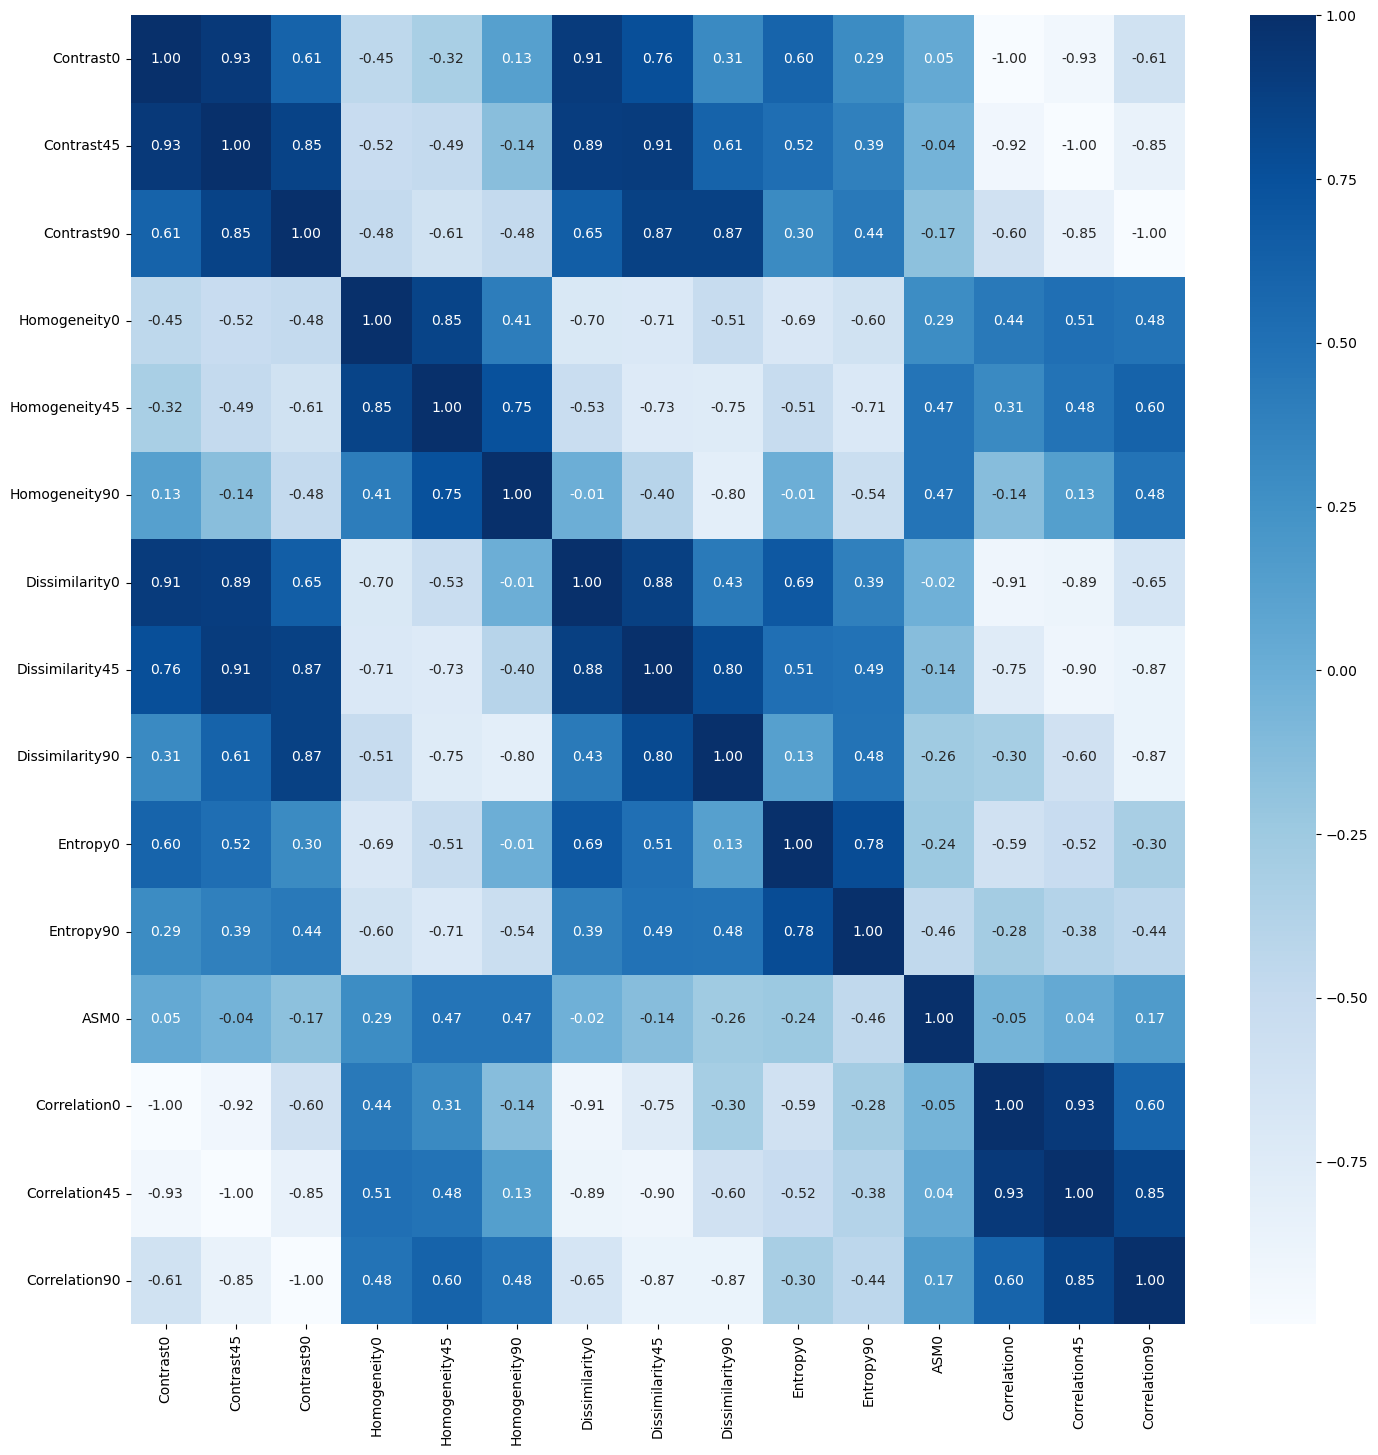

In [94]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [95]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 15)
(40, 15)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [96]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [97]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [98]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.99      0.99      0.99        79
   ScolFinal       0.99      0.99      0.99        81

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

[[78  1]
 [ 1 80]]
Accuracy: 0.9875

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       0.89      0.81      0.85        21
   ScolFinal       0.81      0.89      0.85        19

    accuracy                           0.85        40
   macro avg       0.85      0.85      0.85        40
weighted avg       0.85      0.85      0.85        40

[[17  4]
 [ 2 17]]
Accuracy: 0.85


### Train SVM Classifier

In [99]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.80      0.97      0.88        79
   ScolFinal       0.97      0.77      0.86        81

    accuracy                           0.87       160
   macro avg       0.89      0.87      0.87       160
weighted avg       0.89      0.87      0.87       160

[[77  2]
 [19 62]]
Accuracy: 0.86875

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       0.74      0.95      0.83        21
   ScolFinal       0.92      0.63      0.75        19

    accuracy                           0.80        40
   macro avg       0.83      0.79      0.79        40
weighted avg       0.83      0.80      0.79        40

[[20  1]
 [ 7 12]]
Accuracy: 0.8


### Train KNN Classifier

In [100]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

 NormalFinal       0.90      0.94      0.92        79
   ScolFinal       0.94      0.90      0.92        81

    accuracy                           0.92       160
   macro avg       0.92      0.92      0.92       160
weighted avg       0.92      0.92      0.92       160

[[74  5]
 [ 8 73]]
Accuracy: 0.91875

------Testing Set------
              precision    recall  f1-score   support

 NormalFinal       0.84      0.76      0.80        21
   ScolFinal       0.76      0.84      0.80        19

    accuracy                           0.80        40
   macro avg       0.80      0.80      0.80        40
weighted avg       0.80      0.80      0.80        40

[[16  5]
 [ 3 16]]
Accuracy: 0.8


## Evaluation With Confusion Matrix

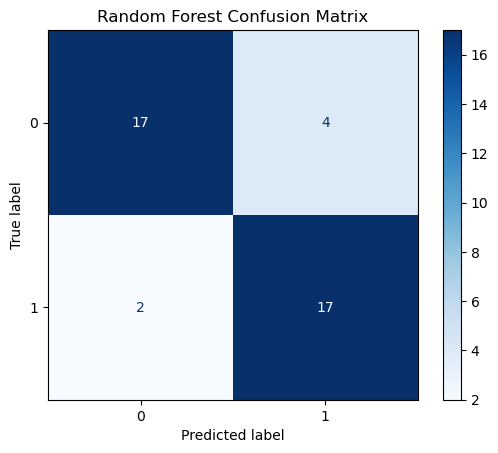

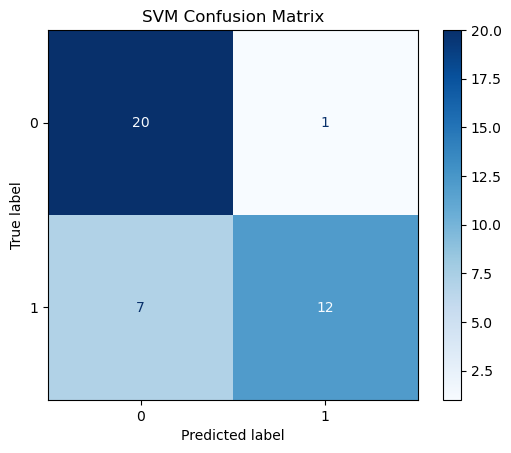

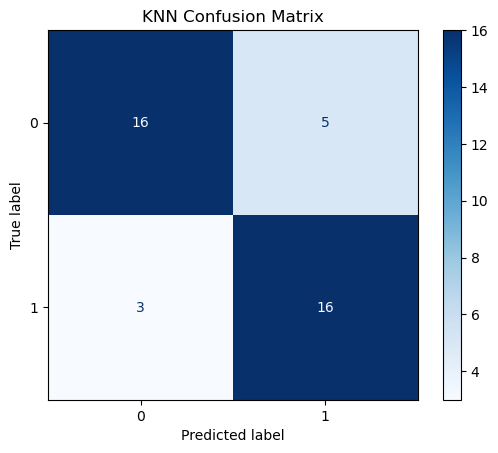

In [101]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")